#注意事项:
#当运行本Notebook的程序后，如果要关闭Notebook，请选择菜单: File > Close and Halt 才能确实停止当前正在运行的程序，并且释放资源
#如果没有使用以上方法，只关闭此分页，程序仍在运行，未释放资源，当您打开并运行其他的Notebook，可能会发生错误

In [1]:
from pyspark import SparkConf
from pyspark.sql import SparkSession

conf = SparkConf().setAppName('rdd_df').setMaster('local')
spark = SparkSession.builder.config(conf=conf).getOrCreate()
sc = spark.sparkContext


In [2]:
sc.master

'local'

In [3]:
if spark.conf.get('spark.sql.execution.arrow.enabled') != 'true':
    spark.conf.set("spark.sql.execution.arrow.enabled", 'true')

In [4]:
global Path    
if sc.master[0:5]=="local" :
   Path="file:///mnt/data1/workspace/data_analysis_mining/Python+Spark2.0+Hadoop机器学习与大数据实战/pythonsparkexample/PythonProject/"
else:   
   Path="hdfs://master:9000/user/hduser/"
#如果要在cluster模式运行(hadoop yarn 或Spark Stand alone)，请按照书上的说明，先把文件上传到HDFS目录

# 19.3	建立RDD、DataFrame与Spark SQL tempTable


In [3]:
#Step 1  读取文本文件,建立RDD

In [5]:
RawUserRDD= sc.textFile(Path+"data/u.user")

In [7]:
RawUserRDD.count()

943

In [8]:
RawUserRDD.take(7)

['1|24|M|technician|85711',
 '2|53|F|other|94043',
 '3|23|M|writer|32067',
 '4|24|M|technician|43537',
 '5|33|F|other|15213',
 '6|42|M|executive|98101',
 '7|57|M|administrator|91344']

In [9]:
userRDD = RawUserRDD.map(lambda line: line.split("|"))
userRDD.take(5)

[['1', '24', 'M', 'technician', '85711'],
 ['2', '53', 'F', 'other', '94043'],
 ['3', '23', 'M', 'writer', '32067'],
 ['4', '24', 'M', 'technician', '43537'],
 ['5', '33', 'F', 'other', '15213']]

# 建立DataFrame

In [8]:
# sqlContext = SparkSession.builder.getOrCreate()

In [10]:
from pyspark.sql import Row
User = Row('userid', "age", 'gender', 'occupation', 'zipcode')
user_ROWs = userRDD.map(lambda x: User(int(x[0]), int(x[1]), x[2], x[3], x[4]))
user_ROWs

PythonRDD[5] at RDD at PythonRDD.scala:53

In [11]:
user_ROWs.take(5)

[Row(userid=1, age=24, gender='M', occupation='technician', zipcode='85711'),
 Row(userid=2, age=53, gender='F', occupation='other', zipcode='94043'),
 Row(userid=3, age=23, gender='M', occupation='writer', zipcode='32067'),
 Row(userid=4, age=24, gender='M', occupation='technician', zipcode='43537'),
 Row(userid=5, age=33, gender='F', occupation='other', zipcode='15213')]

In [9]:
from pyspark.sql import Row
user_Rows = userRDD.map(lambda p:
     Row(
         userid=int(p[0]), 
         age=int(p[1]),
         gender=p[2],
         occupation=p[3],
         zipcode=p[4]
    )
)
user_Rows.take(5)

[Row(age=24, gender=u'M', occupation=u'technician', userid=1, zipcode=u'85711'),
 Row(age=53, gender=u'F', occupation=u'other', userid=2, zipcode=u'94043'),
 Row(age=23, gender=u'M', occupation=u'writer', userid=3, zipcode=u'32067'),
 Row(age=24, gender=u'M', occupation=u'technician', userid=4, zipcode=u'43537'),
 Row(age=33, gender=u'F', occupation=u'other', userid=5, zipcode=u'15213')]

In [12]:
user_df = spark.createDataFrame(user_ROWs)
user_df.printSchema()

root
 |-- userid: long (nullable = true)
 |-- age: long (nullable = true)
 |-- gender: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- zipcode: string (nullable = true)



In [13]:
user_df.show(5)

+------+---+------+----------+-------+
|userid|age|gender|occupation|zipcode|
+------+---+------+----------+-------+
|     1| 24|     M|technician|  85711|
|     2| 53|     F|     other|  94043|
|     3| 23|     M|    writer|  32067|
|     4| 24|     M|technician|  43537|
|     5| 33|     F|     other|  15213|
+------+---+------+----------+-------+
only showing top 5 rows



In [14]:
df=user_df.alias("df")
df.show(5)

+------+---+------+----------+-------+
|userid|age|gender|occupation|zipcode|
+------+---+------+----------+-------+
|     1| 24|     M|technician|  85711|
|     2| 53|     F|     other|  94043|
|     3| 23|     M|    writer|  32067|
|     4| 24|     M|technician|  43537|
|     5| 33|     F|     other|  15213|
+------+---+------+----------+-------+
only showing top 5 rows



In [15]:
# 第二种方法创建
from pyspark.sql.types import *

fields = [
    StructField('userid', IntegerType(), True),
    StructField('age', IntegerType(), True),
    StructField('gender', StringType(), True),
    StructField('occupation', StringType(), True),
    StructField("zipcode", StringType(), True)
    ]
schema = StructType(fields=fields)

In [16]:
use_rdd = userRDD.map(lambda x: [int(x[0]), int(x[1]), x[2], x[3], x[4]])

In [17]:
user_df2 = spark.createDataFrame(use_rdd, schema)
user_df2.printSchema()

root
 |-- userid: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- zipcode: string (nullable = true)



In [18]:
user_df2.show(5)

+------+---+------+----------+-------+
|userid|age|gender|occupation|zipcode|
+------+---+------+----------+-------+
|     1| 24|     M|technician|  85711|
|     2| 53|     F|     other|  94043|
|     3| 23|     M|    writer|  32067|
|     4| 24|     M|technician|  43537|
|     5| 33|     F|     other|  15213|
+------+---+------+----------+-------+
only showing top 5 rows



# 建立Spark SQL tempTable

In [19]:
user_df2.createOrReplaceTempView("user_table")

In [20]:
spark.sql("select count(*) counts from user_table").show()
# sqlContext.sql(" SELECT count(*) counts FROM user_table").show()

+------+
|counts|
+------+
|   943|
+------+



In [21]:
spark.sql("""
SELECT count(*) counts 
FROM   user_table
""").show()

+------+
|counts|
+------+
|   943|
+------+



In [22]:
spark.sql(" SELECT *  FROM user_table ").show()

+------+---+------+-------------+-------+
|userid|age|gender|   occupation|zipcode|
+------+---+------+-------------+-------+
|     1| 24|     M|   technician|  85711|
|     2| 53|     F|        other|  94043|
|     3| 23|     M|       writer|  32067|
|     4| 24|     M|   technician|  43537|
|     5| 33|     F|        other|  15213|
|     6| 42|     M|    executive|  98101|
|     7| 57|     M|administrator|  91344|
|     8| 36|     M|administrator|  05201|
|     9| 29|     M|      student|  01002|
|    10| 53|     M|       lawyer|  90703|
|    11| 39|     F|        other|  30329|
|    12| 28|     F|        other|  06405|
|    13| 47|     M|     educator|  29206|
|    14| 45|     M|    scientist|  55106|
|    15| 49|     F|     educator|  97301|
|    16| 21|     M|entertainment|  10309|
|    17| 30|     M|   programmer|  06355|
|    18| 35|     F|        other|  37212|
|    19| 40|     M|    librarian|  02138|
|    20| 42|     F|    homemaker|  95660|
+------+---+------+-------------+-

In [23]:
spark.sql(" SELECT *  FROM user_table").show(5)

+------+---+------+----------+-------+
|userid|age|gender|occupation|zipcode|
+------+---+------+----------+-------+
|     1| 24|     M|technician|  85711|
|     2| 53|     F|     other|  94043|
|     3| 23|     M|    writer|  32067|
|     4| 24|     M|technician|  43537|
|     5| 33|     F|     other|  15213|
+------+---+------+----------+-------+
only showing top 5 rows



In [24]:
spark.sql(" SELECT *  FROM user_table LIMIT 5").show()

+------+---+------+----------+-------+
|userid|age|gender|occupation|zipcode|
+------+---+------+----------+-------+
|     1| 24|     M|technician|  85711|
|     2| 53|     F|     other|  94043|
|     3| 23|     M|    writer|  32067|
|     4| 24|     M|technician|  43537|
|     5| 33|     F|     other|  15213|
+------+---+------+----------+-------+



# 19.3	显示部分字段

In [43]:
userRDDnew= userRDD.map(lambda x: (x[0],x[3],x[2] ,x[1]) )
userRDDnew.take(5)

[('1', 'technician', 'M', '24'),
 ('2', 'other', 'F', '53'),
 ('3', 'writer', 'M', '23'),
 ('4', 'technician', 'M', '24'),
 ('5', 'other', 'F', '33')]

In [44]:
user_df.select("userid","occupation","gender","age").show(5)

+------+----------+------+---+
|userid|occupation|gender|age|
+------+----------+------+---+
|     1|technician|     M| 24|
|     2|     other|     F| 53|
|     3|    writer|     M| 23|
|     4|technician|     M| 24|
|     5|     other|     F| 33|
+------+----------+------+---+
only showing top 5 rows



In [45]:
user_df.select( user_df.userid, user_df.occupation,user_df.gender,user_df.age ).show(5)

+------+----------+------+---+
|userid|occupation|gender|age|
+------+----------+------+---+
|     1|technician|     M| 24|
|     2|     other|     F| 53|
|     3|    writer|     M| 23|
|     4|technician|     M| 24|
|     5|     other|     F| 33|
+------+----------+------+---+
only showing top 5 rows



In [46]:
df.select(df.userid,df.occupation,df.gender,df.age  ).show(5)

+------+----------+------+---+
|userid|occupation|gender|age|
+------+----------+------+---+
|     1|technician|     M| 24|
|     2|     other|     F| 53|
|     3|    writer|     M| 23|
|     4|technician|     M| 24|
|     5|     other|     F| 33|
+------+----------+------+---+
only showing top 5 rows



In [47]:
# df 是 user_df 的别名
user_df.select(user_df.userid, user_df.occupation,df.gender,df.age ).show(5)

+------+----------+------+---+
|userid|occupation|gender|age|
+------+----------+------+---+
|     1|technician|     M| 24|
|     2|     other|     F| 53|
|     3|    writer|     M| 23|
|     4|technician|     M| 24|
|     5|     other|     F| 33|
+------+----------+------+---+
only showing top 5 rows



In [53]:
df[[df['userid']]].show(5)  # [] 保持dataframe 结构

+------+
|userid|
+------+
|     1|
|     2|
|     3|
|     4|
|     5|
+------+
only showing top 5 rows



In [55]:
df[['userid']].show(5)

+------+
|userid|
+------+
|     1|
|     2|
|     3|
|     4|
|     5|
+------+
only showing top 5 rows



In [51]:
df[df['userid'],df['occupation'],df['gender'],df['age']  ].show(5)

+------+----------+------+---+
|userid|occupation|gender|age|
+------+----------+------+---+
|     1|technician|     M| 24|
|     2|     other|     F| 53|
|     3|    writer|     M| 23|
|     4|technician|     M| 24|
|     5|     other|     F| 33|
+------+----------+------+---+
only showing top 5 rows



In [56]:
spark.sql(" SELECT userid,occupation,gender,age  FROM user_table").show(5)

+------+----------+------+---+
|userid|occupation|gender|age|
+------+----------+------+---+
|     1|technician|     M| 24|
|     2|     other|     F| 53|
|     3|    writer|     M| 23|
|     4|technician|     M| 24|
|     5|     other|     F| 33|
+------+----------+------+---+
only showing top 5 rows



# 19.4 增加计算字段

In [25]:
userRDDnew= userRDD.map(lambda x: (x[0],x[3],x[2],x[1] ,2016-int(x[1])) )
userRDDnew.take(5)

[('1', 'technician', 'M', '24', 1992),
 ('2', 'other', 'F', '53', 1963),
 ('3', 'writer', 'M', '23', 1993),
 ('4', 'technician', 'M', '24', 1992),
 ('5', 'other', 'F', '33', 1983)]

In [26]:
df.select("userid","occupation","gender","age",(2016-df.age).alias('birth_year')).show(5)

+------+----------+------+---+----------+
|userid|occupation|gender|age|birth_year|
+------+----------+------+---+----------+
|     1|technician|     M| 24|      1992|
|     2|     other|     F| 53|      1963|
|     3|    writer|     M| 23|      1993|
|     4|technician|     M| 24|      1992|
|     5|     other|     F| 33|      1983|
+------+----------+------+---+----------+
only showing top 5 rows



In [28]:
spark.sql("""
SELECT userid,occupation,gender,age,2016-age birthyear 
FROM user_table""").show(5)

+------+----------+------+---+---------+
|userid|occupation|gender|age|birthyear|
+------+----------+------+---+---------+
|     1|technician|     M| 24|     1992|
|     2|     other|     F| 53|     1963|
|     3|    writer|     M| 23|     1993|
|     4|technician|     M| 24|     1992|
|     5|     other|     F| 33|     1983|
+------+----------+------+---+---------+
only showing top 5 rows



# 19.5筛选数据

In [29]:
userRDD.filter(lambda r: r[3] == 'technician' and r[2] == 'M' and r[1] == '24').count()

6

In [30]:
userRDD.filter(lambda r:   r[3]=='technician' and r[2]=='M' and r[1]=='24').take(6)    

[['1', '24', 'M', 'technician', '85711'],
 ['4', '24', 'M', 'technician', '43537'],
 ['456', '24', 'M', 'technician', '31820'],
 ['717', '24', 'M', 'technician', '84105'],
 ['832', '24', 'M', 'technician', '77042'],
 ['889', '24', 'M', 'technician', '78704']]

In [31]:
user_df.filter("occupation='technician' ").filter("gender='M' ").filter("age=24").show()

+------+---+------+----------+-------+
|userid|age|gender|occupation|zipcode|
+------+---+------+----------+-------+
|     1| 24|     M|technician|  85711|
|     4| 24|     M|technician|  43537|
|   456| 24|     M|technician|  31820|
|   717| 24|     M|technician|  84105|
|   832| 24|     M|technician|  77042|
|   889| 24|     M|technician|  78704|
+------+---+------+----------+-------+



In [32]:
user_df.filter("occupation='technician' and gender='M' and age=24").show()

+------+---+------+----------+-------+
|userid|age|gender|occupation|zipcode|
+------+---+------+----------+-------+
|     1| 24|     M|technician|  85711|
|     4| 24|     M|technician|  43537|
|   456| 24|     M|technician|  31820|
|   717| 24|     M|technician|  84105|
|   832| 24|     M|technician|  77042|
|   889| 24|     M|technician|  78704|
+------+---+------+----------+-------+



In [66]:
# 使用 & == 
df.filter((df.occupation=='technician' ) & (df.gender=='M' ) & (df.age==24)).show()

+------+---+------+----------+-------+
|userid|age|gender|occupation|zipcode|
+------+---+------+----------+-------+
|     1| 24|     M|technician|  85711|
|     4| 24|     M|technician|  43537|
|   456| 24|     M|technician|  31820|
|   717| 24|     M|technician|  84105|
|   832| 24|     M|technician|  77042|
|   889| 24|     M|technician|  78704|
+------+---+------+----------+-------+



In [67]:
df.filter((df['occupation']=='technician' ) & (df['gender']=='M' ) & (df['age']==24)).show()

+------+---+------+----------+-------+
|userid|age|gender|occupation|zipcode|
+------+---+------+----------+-------+
|     1| 24|     M|technician|  85711|
|     4| 24|     M|technician|  43537|
|   456| 24|     M|technician|  31820|
|   717| 24|     M|technician|  84105|
|   832| 24|     M|technician|  77042|
|   889| 24|     M|technician|  78704|
+------+---+------+----------+-------+



In [35]:
#Step3 使用Spark SQL 筛选数据

In [33]:
spark.sql("""
select * from user_table
where occupation = 'technician' and gender = 'M' and age = 24
""").show(5)

+------+---+------+----------+-------+
|userid|age|gender|occupation|zipcode|
+------+---+------+----------+-------+
|     1| 24|     M|technician|  85711|
|     4| 24|     M|technician|  43537|
|   456| 24|     M|technician|  31820|
|   717| 24|     M|technician|  84105|
|   832| 24|     M|technician|  77042|
+------+---+------+----------+-------+
only showing top 5 rows



# 19.6 筛选数据

In [71]:
#Step1 使用多个filter筛选数据
user_df.filter("occupation='technician' ").filter("gender='M' ").filter("age=24").show(5)

+------+---+------+----------+-------+
|userid|age|gender|occupation|zipcode|
+------+---+------+----------+-------+
|     1| 24|     M|technician|  85711|
|     4| 24|     M|technician|  43537|
|   456| 24|     M|technician|  31820|
|   717| 24|     M|technician|  84105|
|   832| 24|     M|technician|  77042|
+------+---+------+----------+-------+
only showing top 5 rows



In [72]:
user_df.filter("occupation='technician' and gender='M' and age=24").show()

+------+---+------+----------+-------+
|userid|age|gender|occupation|zipcode|
+------+---+------+----------+-------+
|     1| 24|     M|technician|  85711|
|     4| 24|     M|technician|  43537|
|   456| 24|     M|technician|  31820|
|   717| 24|     M|technician|  84105|
|   832| 24|     M|technician|  77042|
|   889| 24|     M|technician|  78704|
+------+---+------+----------+-------+



In [73]:
user_df.filter(user_df.occupation=='technician' ).filter(user_df.gender=='M' ).filter(user_df.age==24).show()

+------+---+------+----------+-------+
|userid|age|gender|occupation|zipcode|
+------+---+------+----------+-------+
|     1| 24|     M|technician|  85711|
|     4| 24|     M|technician|  43537|
|   456| 24|     M|technician|  31820|
|   717| 24|     M|technician|  84105|
|   832| 24|     M|technician|  77042|
|   889| 24|     M|technician|  78704|
+------+---+------+----------+-------+



In [75]:
df.filter((df['occupation']=='technician' ) & (df['gender']=='M' ) &  (df['age']==24)).show()

+------+---+------+----------+-------+
|userid|age|gender|occupation|zipcode|
+------+---+------+----------+-------+
|     1| 24|     M|technician|  85711|
|     4| 24|     M|technician|  43537|
|   456| 24|     M|technician|  31820|
|   717| 24|     M|technician|  84105|
|   832| 24|     M|technician|  77042|
|   889| 24|     M|technician|  78704|
+------+---+------+----------+-------+



# 19.6 单个字段排序数据

In [34]:
userRDD.takeOrdered(5, key = lambda x: int(x[1]))

[['30', '7', 'M', 'student', '55436'],
 ['471', '10', 'M', 'student', '77459'],
 ['289', '11', 'M', 'none', '94619'],
 ['142', '13', 'M', 'other', '48118'],
 ['609', '13', 'F', 'student', '55106']]

In [35]:
userRDD.takeOrdered(6, key= lambda x: -1*int(x[1]))  # 降序

[['481', '73', 'M', 'retired', '37771'],
 ['767', '70', 'M', 'engineer', '00000'],
 ['803', '70', 'M', 'administrator', '78212'],
 ['860', '70', 'F', 'retired', '48322'],
 ['559', '69', 'M', 'executive', '10022'],
 ['585', '69', 'M', 'librarian', '98501']]

In [36]:
spark.sql("""
SELECT userid,occupation,gender,age   
FROM user_table 
ORDER BY age""").show(5)

+------+----------+------+---+
|userid|occupation|gender|age|
+------+----------+------+---+
|    30|   student|     M|  7|
|   471|   student|     M| 10|
|   289|      none|     M| 11|
|   142|     other|     M| 13|
|   609|   student|     F| 13|
+------+----------+------+---+
only showing top 5 rows



In [37]:
spark.sql("""
SELECT userid,occupation,gender,age   
FROM user_table 
ORDER BY age DESC""").show(5)

+------+-------------+------+---+
|userid|   occupation|gender|age|
+------+-------------+------+---+
|   481|      retired|     M| 73|
|   767|     engineer|     M| 70|
|   860|      retired|     F| 70|
|   803|administrator|     M| 70|
|   559|    executive|     M| 69|
+------+-------------+------+---+
only showing top 5 rows



In [83]:
user_df.select('userid', 'occupation', 'gender', 'age').orderBy('age').show(5)

+------+----------+------+---+
|userid|occupation|gender|age|
+------+----------+------+---+
|    30|   student|     M|  7|
|   471|   student|     M| 10|
|   289|      none|     M| 11|
|   142|     other|     M| 13|
|   609|   student|     F| 13|
+------+----------+------+---+
only showing top 5 rows



In [38]:
df.select("userid","occupation","gender","age").orderBy("age",ascending=False).show(5)

+------+-------------+------+---+
|userid|   occupation|gender|age|
+------+-------------+------+---+
|   481|      retired|     M| 73|
|   767|     engineer|     M| 70|
|   860|      retired|     F| 70|
|   803|administrator|     M| 70|
|   559|    executive|     M| 69|
+------+-------------+------+---+
only showing top 5 rows



In [39]:
df.select("userid","occupation","gender","age").orderBy(df.age).show(5)

+------+----------+------+---+
|userid|occupation|gender|age|
+------+----------+------+---+
|    30|   student|     M|  7|
|   471|   student|     M| 10|
|   289|      none|     M| 11|
|   142|     other|     M| 13|
|   609|   student|     F| 13|
+------+----------+------+---+
only showing top 5 rows



In [41]:
import pyspark.sql.functions as fn

In [42]:
df.select("userid","occupation","gender","age").orderBy(fn.desc('age')).show(5)

+------+-------------+------+---+
|userid|   occupation|gender|age|
+------+-------------+------+---+
|   481|      retired|     M| 73|
|   767|     engineer|     M| 70|
|   860|      retired|     F| 70|
|   803|administrator|     M| 70|
|   559|    executive|     M| 69|
+------+-------------+------+---+
only showing top 5 rows



In [43]:
df.select("userid","occupation","gender","age").orderBy(df.age.desc()).show(5)

+------+-------------+------+---+
|userid|   occupation|gender|age|
+------+-------------+------+---+
|   481|      retired|     M| 73|
|   767|     engineer|     M| 70|
|   860|      retired|     F| 70|
|   803|administrator|     M| 70|
|   559|    executive|     M| 69|
+------+-------------+------+---+
only showing top 5 rows



# 19.7 多字段排序数据

In [44]:
userRDD.takeOrdered(5, key = lambda x: (-int(x[1]), x[2] ) )

[['481', '73', 'M', 'retired', '37771'],
 ['860', '70', 'F', 'retired', '48322'],
 ['767', '70', 'M', 'engineer', '00000'],
 ['803', '70', 'M', 'administrator', '78212'],
 ['559', '69', 'M', 'executive', '10022']]

In [45]:
spark.sql("""
SELECT userid, age, gender,occupation,zipcode
FROM user_table
ORDER BY age DESC,gender """).show(5)

+------+---+------+-------------+-------+
|userid|age|gender|   occupation|zipcode|
+------+---+------+-------------+-------+
|   481| 73|     M|      retired|  37771|
|   860| 70|     F|      retired|  48322|
|   767| 70|     M|     engineer|  00000|
|   803| 70|     M|administrator|  78212|
|   559| 69|     M|    executive|  10022|
+------+---+------+-------------+-------+
only showing top 5 rows



In [46]:
df.orderBy(["age","gender"], ascending=[0,1] ).show(5)

+------+---+------+-------------+-------+
|userid|age|gender|   occupation|zipcode|
+------+---+------+-------------+-------+
|   481| 73|     M|      retired|  37771|
|   860| 70|     F|      retired|  48322|
|   767| 70|     M|     engineer|  00000|
|   803| 70|     M|administrator|  78212|
|   559| 69|     M|    executive|  10022|
+------+---+------+-------------+-------+
only showing top 5 rows



In [47]:
df.orderBy(df.age.desc(), df.gender).show(5)

+------+---+------+-------------+-------+
|userid|age|gender|   occupation|zipcode|
+------+---+------+-------------+-------+
|   481| 73|     M|      retired|  37771|
|   860| 70|     F|      retired|  48322|
|   767| 70|     M|     engineer|  00000|
|   803| 70|     M|administrator|  78212|
|   559| 69|     M|    executive|  10022|
+------+---+------+-------------+-------+
only showing top 5 rows



In [48]:
df.orderBy(fn.desc('age'), 'gender').show(5)

+------+---+------+-------------+-------+
|userid|age|gender|   occupation|zipcode|
+------+---+------+-------------+-------+
|   481| 73|     M|      retired|  37771|
|   860| 70|     F|      retired|  48322|
|   767| 70|     M|     engineer|  00000|
|   803| 70|     M|administrator|  78212|
|   559| 69|     M|    executive|  10022|
+------+---+------+-------------+-------+
only showing top 5 rows



# 19.8 显示不重复数据

In [49]:
userRDD.map( lambda x:x[2] ).distinct().collect()

['M', 'F']

In [50]:
userRDD.map( lambda x:(x[1],x[2]) ).distinct().take(20)

[('24', 'M'),
 ('53', 'F'),
 ('23', 'M'),
 ('33', 'F'),
 ('42', 'M'),
 ('57', 'M'),
 ('36', 'M'),
 ('29', 'M'),
 ('53', 'M'),
 ('39', 'F'),
 ('28', 'F'),
 ('47', 'M'),
 ('45', 'M'),
 ('49', 'F'),
 ('21', 'M'),
 ('30', 'M'),
 ('35', 'F'),
 ('40', 'M'),
 ('42', 'F'),
 ('26', 'M')]

In [51]:
spark.sql("SELECT distinct gender FROM user_table").show()

+------+
|gender|
+------+
|     F|
|     M|
+------+



In [52]:
spark.sql("SELECT distinct age, gender FROM user_table").show()

+---+------+
|age|gender|
+---+------+
| 45|     M|
| 62|     F|
| 24|     M|
| 30|     F|
| 18|     F|
| 31|     F|
| 23|     F|
| 34|     M|
| 48|     F|
| 15|     M|
| 40|     F|
| 48|     M|
| 57|     F|
| 42|     F|
| 26|     F|
| 37|     M|
| 70|     F|
| 49|     F|
| 25|     F|
| 19|     M|
+---+------+
only showing top 20 rows



In [53]:
user_df.select("gender").distinct().show()

+------+
|gender|
+------+
|     F|
|     M|
+------+



In [54]:
user_df.select("age","gender").distinct().show()

+---+------+
|age|gender|
+---+------+
| 39|     F|
| 48|     M|
| 26|     M|
| 28|     M|
| 54|     M|
| 60|     M|
| 50|     M|
| 53|     F|
| 30|     M|
| 48|     F|
| 47|     M|
| 46|     M|
| 56|     M|
| 32|     M|
| 31|     M|
| 53|     M|
| 20|     F|
| 29|     F|
| 21|     F|
| 42|     M|
+---+------+
only showing top 20 rows



# 19.9	分组统计数据

In [105]:
# RDD 分组统计性别  使用MapReduce
userRDD.map(lambda x: (x[2], 1)).reduceByKey(lambda x, y: x+y).collect()

[('M', 670), ('F', 273)]

In [106]:
df.columns

['userid', 'age', 'gender', 'occupation', 'zipcode']

In [109]:
# 按性别 职业统计
userRDD.map(lambda x: ((x[2], x[3]), 1)).reduceByKey(lambda x, y: x+y).sortBy(lambda x: -x[1]).collect()

[(('M', 'student'), 136),
 (('M', 'educator'), 69),
 (('M', 'other'), 69),
 (('M', 'engineer'), 65),
 (('M', 'programmer'), 60),
 (('F', 'student'), 60),
 (('M', 'administrator'), 43),
 (('F', 'other'), 36),
 (('F', 'administrator'), 36),
 (('M', 'executive'), 29),
 (('F', 'librarian'), 29),
 (('M', 'scientist'), 28),
 (('M', 'technician'), 26),
 (('M', 'writer'), 26),
 (('F', 'educator'), 26),
 (('M', 'librarian'), 22),
 (('F', 'writer'), 19),
 (('M', 'entertainment'), 16),
 (('M', 'marketing'), 16),
 (('M', 'artist'), 15),
 (('F', 'artist'), 13),
 (('M', 'retired'), 13),
 (('F', 'healthcare'), 11),
 (('M', 'lawyer'), 10),
 (('F', 'marketing'), 10),
 (('M', 'salesman'), 9),
 (('M', 'doctor'), 7),
 (('F', 'homemaker'), 6),
 (('F', 'programmer'), 6),
 (('M', 'none'), 5),
 (('M', 'healthcare'), 5),
 (('F', 'none'), 4),
 (('F', 'executive'), 3),
 (('F', 'scientist'), 3),
 (('F', 'salesman'), 3),
 (('F', 'lawyer'), 2),
 (('F', 'entertainment'), 2),
 (('F', 'engineer'), 2),
 (('F', 'retired

In [55]:
userRDD.map(lambda x: ((x[2], x[3]), 1)).reduceByKey(lambda x, y: x+y).takeOrdered(5, key=lambda x: -x[1])

[(('M', 'student'), 136),
 (('M', 'educator'), 69),
 (('M', 'other'), 69),
 (('M', 'engineer'), 65),
 (('M', 'programmer'), 60)]

In [56]:
spark.sql(""" 
SELECT gender ,count(*)  counts  
FROM   user_table 
GROUP BY gender""").show()

+------+------+
|gender|counts|
+------+------+
|     F|   273|
|     M|   670|
+------+------+



In [57]:
spark.sql(""" 
SELECT gender,occupation,count(*) counts  
FROM   user_table 
GROUP BY gender,occupation
""").show(100)

+------+-------------+------+
|gender|   occupation|counts|
+------+-------------+------+
|     M|    executive|    29|
|     M|     educator|    69|
|     F|         none|     4|
|     F|entertainment|     2|
|     F|      retired|     1|
|     F|       artist|    13|
|     F|    librarian|    29|
|     F|     engineer|     2|
|     F|   healthcare|    11|
|     F|administrator|    36|
|     M|        other|    69|
|     M|    homemaker|     1|
|     F|       lawyer|     2|
|     M|   programmer|    60|
|     M|     salesman|     9|
|     M|         none|     5|
|     M|entertainment|    16|
|     M|    marketing|    16|
|     M|   technician|    26|
|     M|administrator|    43|
|     F|    marketing|    10|
|     F|   programmer|     6|
|     F|   technician|     1|
|     F|    executive|     3|
|     M|    scientist|    28|
|     F|     educator|    26|
|     M|      retired|    13|
|     M|   healthcare|     5|
|     M|       writer|    26|
|     M|       lawyer|    10|
|     M|  

In [58]:
user_df.select('gender').groupBy('gender').count().show()

+------+-----+
|gender|count|
+------+-----+
|     F|  273|
|     M|  670|
+------+-----+



In [59]:
user_df.select('gender', 'occupation')\
    .groupby('gender', 'occupation')\
    .count()\
    .orderBy('gender', 'occupation')\
    .show(100)

+------+-------------+-----+
|gender|   occupation|count|
+------+-------------+-----+
|     F|administrator|   36|
|     F|       artist|   13|
|     F|     educator|   26|
|     F|     engineer|    2|
|     F|entertainment|    2|
|     F|    executive|    3|
|     F|   healthcare|   11|
|     F|    homemaker|    6|
|     F|       lawyer|    2|
|     F|    librarian|   29|
|     F|    marketing|   10|
|     F|         none|    4|
|     F|        other|   36|
|     F|   programmer|    6|
|     F|      retired|    1|
|     F|     salesman|    3|
|     F|    scientist|    3|
|     F|      student|   60|
|     F|   technician|    1|
|     F|       writer|   19|
|     M|administrator|   43|
|     M|       artist|   15|
|     M|       doctor|    7|
|     M|     educator|   69|
|     M|     engineer|   65|
|     M|entertainment|   16|
|     M|    executive|   29|
|     M|   healthcare|    5|
|     M|    homemaker|    1|
|     M|       lawyer|   10|
|     M|    librarian|   22|
|     M|    ma

In [122]:
# Computes a pair-wise frequency table of the given columns
user_df.crosstab("occupation","gender").show()

+-----------------+---+---+
|occupation_gender|  F|  M|
+-----------------+---+---+
|        scientist|  3| 28|
|          student| 60|136|
|           writer| 19| 26|
|         salesman|  3|  9|
|          retired|  1| 13|
|    administrator| 36| 43|
|       programmer|  6| 60|
|           doctor|  0|  7|
|        homemaker|  6|  1|
|        executive|  3| 29|
|         engineer|  2| 65|
|    entertainment|  2| 16|
|        marketing| 10| 16|
|       technician|  1| 26|
|           artist| 13| 15|
|        librarian| 29| 22|
|           lawyer|  2| 10|
|         educator| 26| 69|
|       healthcare| 11|  5|
|             none|  4|  5|
+-----------------+---+---+
only showing top 20 rows



In [127]:
# 'gender', 'occupation', 'zipcode'
# 数据透视表
user_df.groupBy('occupation').pivot('gender').mean('age').collect()

[Row(occupation='librarian', F=40.0, M=40.0),
 Row(occupation='retired', F=70.0, M=62.53846153846154),
 Row(occupation='lawyer', F=39.5, M=36.2),
 Row(occupation='none', F=36.5, M=18.6),
 Row(occupation='writer', F=37.63157894736842, M=35.34615384615385),
 Row(occupation='programmer', F=32.166666666666664, M=33.21666666666667),
 Row(occupation='marketing', F=37.2, M=37.875),
 Row(occupation='other', F=35.47222222222222, M=34.028985507246375),
 Row(occupation='executive', F=44.0, M=38.172413793103445),
 Row(occupation='scientist', F=28.333333333333332, M=36.32142857142857),
 Row(occupation='student', F=20.75, M=22.669117647058822),
 Row(occupation='salesman', F=27.0, M=38.55555555555556),
 Row(occupation='artist', F=30.307692307692307, M=32.333333333333336),
 Row(occupation='technician', F=38.0, M=32.96153846153846),
 Row(occupation='administrator', F=40.638888888888886, M=37.16279069767442),
 Row(occupation='engineer', F=29.5, M=36.6),
 Row(occupation='healthcare', F=39.81818181818182,

In [60]:
pdf = user_df.toPandas()
pdf.head(5)

,userid,age,gender,occupation,zipcode
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [130]:
# pandas 的数据透视表
pdf.pivot_table('age', columns='gender', index='occupation', aggfunc='mean')

gender,F,M
occupation,,
administrator,40.638889,37.162791
artist,30.307692,32.333333
doctor,NaN,43.571429
educator,39.115385,43.101449
engineer,29.500000,36.600000
entertainment,31.000000,29.000000
executive,44.000000,38.172414
healthcare,39.818182,45.400000
homemaker,34.166667,23.000000


In [64]:
user_df.describe('age').show()

+-------+-----------------+
|summary|              age|
+-------+-----------------+
|  count|              943|
|   mean|34.05196182396607|
| stddev|12.19273973305903|
|    min|                7|
|    max|               73|
+-------+-----------------+



# 19.10	Join关联数据

# ZipCode

In [68]:
#wget http://federalgovernmentzipcodes.us/free-zipcode-database-Primary.csv

In [65]:
#Path="file:/home/hduser/pythonwork/ipynotebook/"
rawDataWithHeader = sc.textFile(Path+"data/free-zipcode-database-Primary.csv")
rawDataWithHeader.take(2)

['"Zipcode","ZipCodeType","City","State","LocationType","Lat","Long","Location","Decommisioned","TaxReturnsFiled","EstimatedPopulation","TotalWages"',
 '"00705","STANDARD","AIBONITO","PR","PRIMARY",18.14,-66.26,"NA-US-PR-AIBONITO","false",,,']

In [66]:
header = rawDataWithHeader.first()
rawData = rawDataWithHeader.filter(lambda x:x !=header)
rawData.first()

'"00705","STANDARD","AIBONITO","PR","PRIMARY",18.14,-66.26,"NA-US-PR-AIBONITO","false",,,'

In [67]:
rData=rawData.map(lambda x: x.replace("\"", ""))   
rData.first()

'00705,STANDARD,AIBONITO,PR,PRIMARY,18.14,-66.26,NA-US-PR-AIBONITO,false,,,'

In [68]:
ZipRDD = rData.map(lambda x: x.split(","))
ZipRDD.first()

['00705',
 'STANDARD',
 'AIBONITO',
 'PR',
 'PRIMARY',
 '18.14',
 '-66.26',
 'NA-US-PR-AIBONITO',
 'false',
 '',
 '',
 '']

# 19.19.2	建立zipcode_table

In [69]:
from pyspark.sql import Row
zipcode_data =ZipRDD.map(lambda p: 
   Row(
    zipcode=int(p[0]), 
    zipCodeType=p[1],
    city=p[2],
    state=p[3]
    )
)
zipcode_data.take(5)

[Row(city='AIBONITO', state='PR', zipCodeType='STANDARD', zipcode=705),
 Row(city='ANASCO', state='PR', zipCodeType='STANDARD', zipcode=610),
 Row(city='ANGELES', state='PR', zipCodeType='PO BOX', zipcode=611),
 Row(city='ARECIBO', state='PR', zipCodeType='STANDARD', zipcode=612),
 Row(city='ADJUNTAS', state='PR', zipCodeType='STANDARD', zipcode=601)]

In [70]:
zipcode_df = spark.createDataFrame(zipcode_data)
zipcode_df.printSchema()

root
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zipCodeType: string (nullable = true)
 |-- zipcode: long (nullable = true)



In [71]:
zipcode_df.createOrReplaceTempView("zipcode_table")
zipcode_df.show(10)  # zipcode 对应的地址

+---------+-----+-----------+-------+
|     city|state|zipCodeType|zipcode|
+---------+-----+-----------+-------+
| AIBONITO|   PR|   STANDARD|    705|
|   ANASCO|   PR|   STANDARD|    610|
|  ANGELES|   PR|     PO BOX|    611|
|  ARECIBO|   PR|   STANDARD|    612|
| ADJUNTAS|   PR|   STANDARD|    601|
| CASTANER|   PR|     PO BOX|    631|
|   AGUADA|   PR|   STANDARD|    602|
|AGUADILLA|   PR|   STANDARD|    603|
|AGUADILLA|   PR|     PO BOX|    604|
|AGUADILLA|   PR|     PO BOX|    605|
+---------+-----+-----------+-------+
only showing top 10 rows



In [72]:
spark.sql(""" 
SELECT z.* 
FROM zipcode_table z 
""").show(10)

+---------+-----+-----------+-------+
|     city|state|zipCodeType|zipcode|
+---------+-----+-----------+-------+
| AIBONITO|   PR|   STANDARD|    705|
|   ANASCO|   PR|   STANDARD|    610|
|  ANGELES|   PR|     PO BOX|    611|
|  ARECIBO|   PR|   STANDARD|    612|
| ADJUNTAS|   PR|   STANDARD|    601|
| CASTANER|   PR|     PO BOX|    631|
|   AGUADA|   PR|   STANDARD|    602|
|AGUADILLA|   PR|   STANDARD|    603|
|AGUADILLA|   PR|     PO BOX|    604|
|AGUADILLA|   PR|     PO BOX|    605|
+---------+-----+-----------+-------+
only showing top 10 rows



In [74]:
spark.sql(""" 
SELECT u.* ,z.city,z.state 
FROM user_table u 
LEFT JOIN zipcode_table z  ON u.zipcode = z.zipcode
WHERE z.state='NY'
""").show(10)

+------+---+------+-------------+-------+----------------+-----+
|userid|age|gender|   occupation|zipcode|            city|state|
+------+---+------+-------------+-------+----------------+-----+
|   405| 22|     F|   healthcare|  10019|        NEW YORK|   NY|
|   478| 29|     M|        other|  10019|        NEW YORK|   NY|
|   327| 22|     M|      student|  11101|LONG ISLAND CITY|   NY|
|   656| 48|     M|     educator|  10314|   STATEN ISLAND|   NY|
|   617| 27|     F|       writer|  11201|        BROOKLYN|   NY|
|   760| 35|     F|        other|  14211|         BUFFALO|   NY|
|   155| 32|     F|        other|  11217|        BROOKLYN|   NY|
|   557| 30|     F|       writer|  11217|        BROOKLYN|   NY|
|   806| 27|     M|    marketing|  11217|        BROOKLYN|   NY|
|   509| 23|     M|administrator|  10011|        NEW YORK|   NY|
+------+---+------+-------------+-------+----------------+-----+
only showing top 10 rows



In [75]:
spark.sql(""" 
SELECT z.state ,count(*) count
FROM user_table u
LEFT JOIN zipcode_table z  ON u.zipcode = z.zipcode
GROUP BY z.state 
""").show(60)

+-----+-----+
|state|count|
+-----+-----+
|   AZ|   14|
|   SC|   11|
|   LA|    6|
|   MN|   78|
|   NJ|   18|
|   DC|   14|
|   OR|   20|
|   VA|   27|
| null|   35|
|   RI|    3|
|   KY|   11|
|   WY|    1|
|   NH|    6|
|   MI|   23|
|   NV|    3|
|   WI|   22|
|   ID|    7|
|   CA|  116|
|   NE|    6|
|   CT|   17|
|   MT|    2|
|   NC|   19|
|   VT|    5|
|   MD|   27|
|   DE|    3|
|   MO|   17|
|   IL|   50|
|   ME|    2|
|   WA|   24|
|   ND|    2|
|   MS|    3|
|   AL|    3|
|   IN|    9|
|   AE|    1|
|   OH|   32|
|   TN|   12|
|   IA|   14|
|   NM|    2|
|   PA|   34|
|   SD|    1|
|   NY|   60|
|   TX|   51|
|   WV|    3|
|   GA|   19|
|   MA|   35|
|   KS|    4|
|   CO|   20|
|   FL|   24|
|   AK|    5|
|   AR|    1|
|   OK|    9|
|   AP|    1|
|   UT|    9|
|   HI|    2|
+-----+-----+



In [76]:
#user_df.leftOuterJoin(zipcode_df)
# 使用dataframe 的join
joined_df = user_df.join(zipcode_df, 
                         user_df.zipcode == zipcode_df.zipcode,
                         how='left')
joined_df.show(10)

+------+---+------+-------------+-------+-------------+-----+-----------+-------+
|userid|age|gender|   occupation|zipcode|         city|state|zipCodeType|zipcode|
+------+---+------+-------------+-------+-------------+-----+-----------+-------+
|   131| 59|     F|administrator|  15237|   PITTSBURGH|   PA|   STANDARD|  15237|
|   619| 17|     M|      student|  44134|    CLEVELAND|   OH|   STANDARD|  44134|
|   839| 38|     F|entertainment|  90814|   LONG BEACH|   CA|   STANDARD|  90814|
|   409| 48|     M|administrator|  98225|   BELLINGHAM|   WA|   STANDARD|  98225|
|   791| 31|     M|     educator|  20064|   WASHINGTON|   DC|     UNIQUE|  20064|
|   271| 51|     M|     engineer|  22932|       CROZET|   VA|   STANDARD|  22932|
|   375| 17|     M|entertainment|  37777|   LOUISVILLE|   TN|   STANDARD|  37777|
|   272| 33|     M|    scientist|  53706|      MADISON|   WI|   STANDARD|  53706|
|   758| 27|     M|      student|  53706|      MADISON|   WI|   STANDARD|  53706|
|   344| 30|    

In [77]:
joined_df=user_df.join(zipcode_df ,  \
                                 user_df.zipcode == zipcode_df.zipcode, "left_outer")

joined_df.printSchema()    

root
 |-- userid: long (nullable = true)
 |-- age: long (nullable = true)
 |-- gender: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- zipcode: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zipCodeType: string (nullable = true)
 |-- zipcode: long (nullable = true)



In [78]:
joined_df.show(10)

+------+---+------+-------------+-------+-------------+-----+-----------+-------+
|userid|age|gender|   occupation|zipcode|         city|state|zipCodeType|zipcode|
+------+---+------+-------------+-------+-------------+-----+-----------+-------+
|   131| 59|     F|administrator|  15237|   PITTSBURGH|   PA|   STANDARD|  15237|
|   619| 17|     M|      student|  44134|    CLEVELAND|   OH|   STANDARD|  44134|
|   839| 38|     F|entertainment|  90814|   LONG BEACH|   CA|   STANDARD|  90814|
|   409| 48|     M|administrator|  98225|   BELLINGHAM|   WA|   STANDARD|  98225|
|   791| 31|     M|     educator|  20064|   WASHINGTON|   DC|     UNIQUE|  20064|
|   271| 51|     M|     engineer|  22932|       CROZET|   VA|   STANDARD|  22932|
|   375| 17|     M|entertainment|  37777|   LOUISVILLE|   TN|   STANDARD|  37777|
|   272| 33|     M|    scientist|  53706|      MADISON|   WI|   STANDARD|  53706|
|   758| 27|     M|      student|  53706|      MADISON|   WI|   STANDARD|  53706|
|   344| 30|    

In [79]:
joined_df.filter("state='NY' ").show(10)

+------+---+------+-------------+-------+----------------+-----+-----------+-------+
|userid|age|gender|   occupation|zipcode|            city|state|zipCodeType|zipcode|
+------+---+------+-------------+-------+----------------+-----+-----------+-------+
|   405| 22|     F|   healthcare|  10019|        NEW YORK|   NY|   STANDARD|  10019|
|   478| 29|     M|        other|  10019|        NEW YORK|   NY|   STANDARD|  10019|
|   327| 22|     M|      student|  11101|LONG ISLAND CITY|   NY|   STANDARD|  11101|
|   656| 48|     M|     educator|  10314|   STATEN ISLAND|   NY|   STANDARD|  10314|
|   617| 27|     F|       writer|  11201|        BROOKLYN|   NY|   STANDARD|  11201|
|   760| 35|     F|        other|  14211|         BUFFALO|   NY|   STANDARD|  14211|
|   155| 32|     F|        other|  11217|        BROOKLYN|   NY|   STANDARD|  11217|
|   557| 30|     F|       writer|  11217|        BROOKLYN|   NY|   STANDARD|  11217|
|   806| 27|     M|    marketing|  11217|        BROOKLYN|   NY| 

In [82]:
GroupByState_df=joined_df.groupBy("state").count()
GroupByState_df.orderBy('count', ascending=False).show(10)

+-----+-----+
|state|count|
+-----+-----+
|   CA|  116|
|   MN|   78|
|   NY|   60|
|   TX|   51|
|   IL|   50|
| null|   35|
|   MA|   35|
|   PA|   34|
|   OH|   32|
|   VA|   27|
+-----+-----+
only showing top 10 rows



# 19.11	以Pandas DataFrame绘图

In [83]:
import pandas as pd
GroupByState_pandas_df =GroupByState_df.toPandas().set_index('state')
GroupByState_pandas_df.head(10)

,count
state,
AZ,14
SC,11
LA,6
MN,78
NJ,18
DC,14
OR,20
VA,27
NaN,35


In [84]:
GroupByState_pandas_df.T

state,AZ,SC,LA,MN,NJ,DC,OR,VA,NaN,RI,...,MA,KS,CO,FL,AK,AR,OK,AP,UT,HI
count,14,11,6,78,18,14,20,27,35,3,...,35,4,20,24,5,1,9,1,9,2


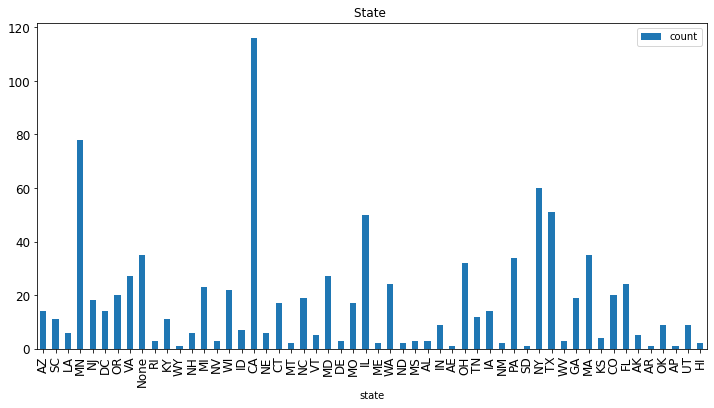

In [85]:
import matplotlib.pyplot as plt
%matplotlib inline
ax = GroupByState_pandas_df['count']\
            .plot(kind='bar', title ="State ",figsize=(12,6), legend=True, fontsize=12)
plt.show()

In [86]:
Occupation_df=spark.sql(""" 
SELECT u.occupation ,count(*) counts
FROM user_table u
GROUP BY occupation
""")
Occupation_df.show(30)

+-------------+------+
|   occupation|counts|
+-------------+------+
|    librarian|    51|
|      retired|    14|
|       lawyer|    12|
|         none|     9|
|       writer|    45|
|   programmer|    66|
|    marketing|    26|
|        other|   105|
|    executive|    32|
|    scientist|    31|
|      student|   196|
|     salesman|    12|
|       artist|    28|
|   technician|    27|
|administrator|    79|
|     engineer|    67|
|   healthcare|    16|
|     educator|    95|
|entertainment|    18|
|    homemaker|     7|
|       doctor|     7|
+-------------+------+



In [87]:
Occupation_pandas_df =Occupation_df.toPandas().set_index('occupation')
Occupation_pandas_df

,counts
occupation,
librarian,51
retired,14
lawyer,12
none,9
writer,45
programmer,66
marketing,26
other,105
executive,32


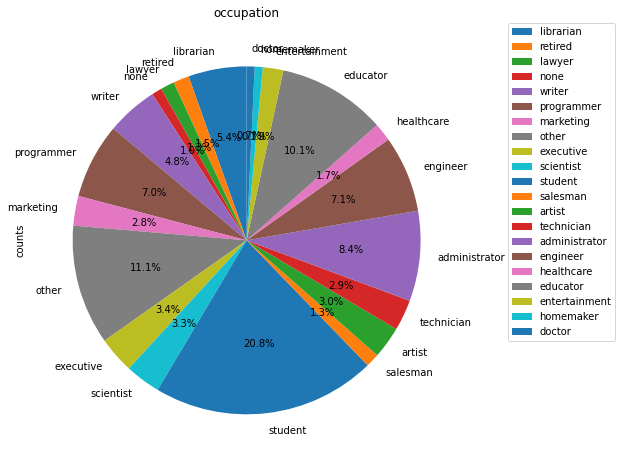

In [91]:
ax =Occupation_pandas_df['counts'].plot(kind='pie',
           title ="occupation", figsize=(10,8), startangle=90, autopct='%1.1f%%')
ax.legend(bbox_to_anchor=(1.1, 1), loc=2, borderaxespad=0.)
plt.show()